# Model Evaluation & Validation
## Predicción de precios de casas en Boston

## Introducción 

En este proyecto, evaluará el rendimiento y el poder predictivo de un modelo que ha sido entrenado y probado con datos recopilados de hogares en los suburbios de Boston, Massachusetts. Un modelo entrenado con estos datos que se considera un *buen ajuste* podría usarse para hacer ciertas predicciones sobre una casa, en particular, su valor monetario. Este modelo probaría ser invaluable para alguien como un agente de bienes raíces que podría hacer uso de dicha información diariamente.

El conjunto de datos de este proyecto se origina en el [Repositorio de aprendizaje automático de UCI](https://archive.ics.uci.edu/ml/datasets/Housing). Los datos de viviendas de Boston se recopilaron en 1978 y cada una de las 506 entradas representa datos agregados sobre 14 características para hogares de varios suburbios en Boston, Massachusetts. Para los propósitos de este proyecto, se han realizado los siguientes pasos de preprocesamiento en el conjunto de datos:

- 16 datos tienen un valor `'MEDV'` de 50.0. Es probable que estos datos contengan ** valores faltantes o censurados ** y se hayan eliminado.
- 1 dato tiene un valor `'RM'` de 8.78. Este dato se puede considerar un ** valor ** extraño y se ha eliminado.
- Las características `'RM'`, `'LSTAT'`, `'PTRATIO'` y `'MEDV'` son esenciales. Las restantes ** características no relevantes ** han sido excluidas.
- La característica `'MEDV'` ha sido ** escalada multiplicativamente ** para dar cuenta de 35 años de inflación en el mercado.


In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py - conda install -c vpython vpython If not installed 
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## Exploración de datos
En esta primera sección del proyecto, realizará una investigación preliminar sobre los datos de vivienda de Boston y proporcionará sus observaciones. Familiarizarse con los datos a través de un proceso exploratorio es una práctica fundamental para ayudarlo a comprender mejor y justificar sus resultados.

Dado que el objetivo principal de este proyecto es construir un modelo que tenga la capacidad de predecir el valor de las casas, tendremos que separar el conjunto de datos en **features** y la **target variable**. Las **features**, `'RM'`, `'LSTAT'` y `'PTRATIO'` nos dan información cuantitativa sobre cada punto de datos. La **target variable**, `'MEDV'`, será la variable que buscamos predecir. Estos se almacenan en `features` y `prices`, respectivamente.

### Calcular estadísticas
Se calculan las estadísticas descriptivas sobre los precios de la vivienda en Boston. Como ya se ha importado `numpy`, se usa esa biblioteca para realizar los cálculos necesarios. Estas estadísticas serán extremadamente importantes más adelante para analizar diversos resultados de predicción del modelo construido.  

In [3]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Observación de los features
Como recordatorio, estamos usando tres funciones del conjunto de datos de viviendas de Boston: `'RM'`,`' LSTAT'` y `'PTRATIO'`. Para cada punto de datos (barrio):
- `'RM'` es el número promedio de habitaciones entre las casas en el vecindario.
- `'LSTAT'` es el porcentaje de propietarios de viviendas en el vecindario considerado de "clase baja" (trabajadores pobres).
- `'PTRATIO'` es la proporción entre estudiantes y maestros en las escuelas primarias y secundarias del vecindario.

**Para analizar...** Usando su intuición, para cada una de las tres características anteriores, ¿cree que un aumento en el valor de esa característica llevaría a un **aumento** en el valor de  `'MEDV'` o una ** disminución ** en el valor de `'MEDV'`?

**Algunas pistas para reflexionar...** Este problema puede expresarse utilizando casos como los siguientes:

* ¿Esperaría que una casa que tiene un valor de `'RM'` (número de habitaciones) de 6 valga más o menos que una casa que tenga un valor de `'RM'` de 7?
* ¿Esperaría que un vecindario que tenga un valor de `'LSTAT'` (porcentaje de trabajadores de clase baja) de 15 tenga un valor de la vivienda más o menos que un vecindario que tenga un valor de `'LSTAT'`?
* ¿Esperaría que un vecindario que tiene un valor de '`'PTRATIO'` (proporción de estudiantes a maestros) de 10 tenga un valor de la vivienda que valga más o menos que un vecindario que tenga un valor de `'PTRATIO'` de 15?

----

## Desarrollando un Modelo

En esta segunda sección del proyecto, se desarrollarán las herramientas y técnicas necesarias para que el modelo realice una predicción. Ser capaz de realizar evaluaciones precisas del rendimiento de cada modelo mediante el uso de estas herramientas y técnicas ayuda a reforzar enormemente la confiabilidad de las predicciones.

### Implementación: definir una métrica de rendimiento

Es difícil medir la calidad de un modelo dado sin cuantificar su desempeño durante el entrenamiento y las pruebas. Esto se hace normalmente utilizando algún tipo de métrica de rendimiento, ya sea mediante el cálculo de algún tipo de error o alguna otra medida útil. Para este proyecto, se calculará el [*coeficiente de determinación*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, para cuantificar el modelo. El coeficiente de determinación para un modelo es una estadística útil en el análisis de regresión, ya que a menudo describe cuán "bueno" es ese modelo para hacer predicciones.

Los valores de R<sup>2</sup> varían de 0 a 1, lo que captura el porcentaje de correlación al cuadrado entre los valores predichos y reales de la **variable objetivo**. Un modelo con un R <sup>2</sup> de 0 no es mejor que un modelo que siempre predice la *media* de la variable objetivo, mientras que un modelo con un R <sup>2</sup> de 1 perfectamente predice la variable objetivo. Cualquier valor entre 0 y 1 indica qué porcentaje de la variable objetivo, usando este modelo, puede explicarse por las **características**. _A un modelo también se le puede dar un R<sup>2</sup> negativo, lo que indica que el modelo es **arbitrariamente peor** que uno que siempre predice la media de la variable objetivo._

Para la función `performance_metric` se implementará lo siguiente:

- Un `r2_score` de` sklearn.metrics` para realizar un cálculo de rendimiento entre `y_true` y` y_predict`.
- Se asignará la puntuación de rendimiento a la variable `puntuación`.

In [4]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Análisis....Que tán bueno es un modelo?
Supongamos que un conjunto de datos contiene cinco valores y que un modelo realizó las siguientes predicciones para la variable de destino:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |


Se ejecuta la celda de código a continuación para usar la función `performance_metric` y calcular el coeficiente de determinación de este modelo:

In [5]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


¿Consideraría que este modelo ha capturado exitosamente la variación de la variable objetivo?

** RECUERDE: ** La puntuación R2 es la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente. En otras palabras:

* La puntuación R2 de 0 significa que la variable dependiente no se puede predecir a partir de la variable independiente.
* La puntuación R2 de 1 significa que la variable dependiente se puede predecir a partir de la variable independiente.
* La puntuación R2 entre 0 y 1 indica la medida en que la variable dependiente es predecible.
* La puntuación de R2 de 0.40 significa que el 40 por ciento de la varianza en Y es predecible a partir de X.

### Implementación: mezclar y dividir los datos

La próxima implementación requiere tomar el conjunto de datos de viviendas de Boston y dividir los datos en subconjuntos de training y testing. Por lo general, los datos también se barajan en un orden aleatorio cuando se crean los subconjuntos de entrenamiento y prueba para eliminar cualquier sesgo en el orden del conjunto de datos.

A continuación, se implementa lo siguiente:
- Se usa `train_test_split` de `sklearn.model_selection` para barajar y dividir los datos de `features` y `prices` en conjuntos de entrenamiento y pruebas.
  - Dividir los datos en 80% de entrenamiento y 20% de prueba.
  - Establezca el `random_state` para `train_test_split` en un valor de su elección. Esto asegura que los resultados sean consistentes.
- Asignan las divisiones de training y testing `X_train`, `X_test`, `y_train`, `y_test`.

In [7]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, random_state=20, test_size=0.2)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Training / Testing

**Analisis...** ¿Cuál es el beneficio de dividir un conjunto de datos en una proporción de subconjuntos de entrenamiento y prueba para un algoritmo de aprendizaje? (analícelo en términos de overfitting y underfitting)

----

## Analizando el rendimiento del modelo
En esta tercera sección del proyecto, daremos un vistazo a los rendimientos de aprendizaje y prueba de varios modelos en varios subconjuntos de datos de entrenamiento. Además, se investigará un algoritmo en particular con un parámetro creciente `'max_depth'` en el conjunto de entrenamiento completo para observar cómo la complejidad del modelo afecta el rendimiento. Graficar el rendimiento de su modelo según diversos criterios puede ser beneficioso en el proceso de análisis, como visualizar un comportamiento que puede no haber sido evidente a partir de los resultados.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.


### Curvas de aprendizaje

La siguiente celda de código produce cuatro gráficos para un modelo de árbol de decisión con diferentes profundidades máximas. Cada gráfico visualiza las curvas de aprendizaje del modelo tanto para el entrenamiento como para las pruebas a medida que aumenta el tamaño del conjunto de entrenamiento. Tenga en cuenta que la región sombreada de una curva de aprendizaje denota la incertidumbre de esa curva (medida como la desviación estándar). El modelo se califica en los conjuntos de entrenamiento y prueba utilizando R<sup>2</sup>, el coeficiente de determinación.

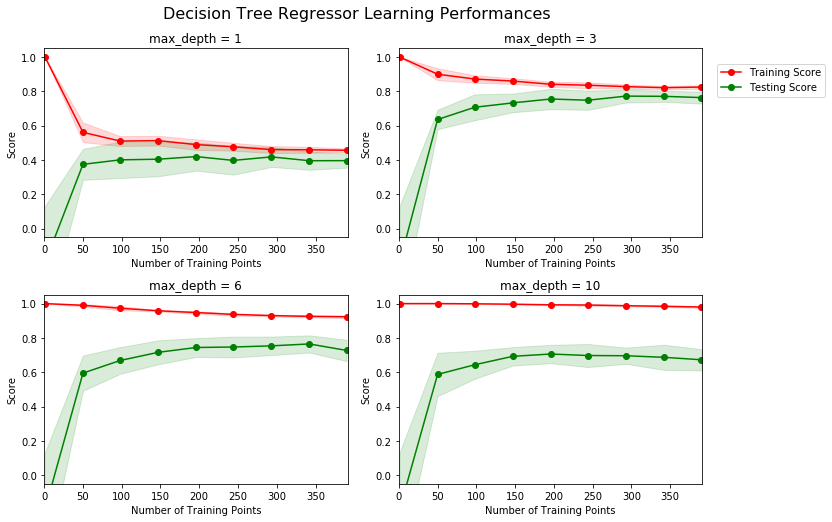

In [8]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Para analizar...aprendiendo de los datos

* Analice el efecto de aumentar la profundidad máxima para el modelo, basado en las curvas anteriores. ¿Qué sucede con la puntuación de la curva de entrenamiento a medida que se agregan más puntos de entrenamiento? ¿Qué pasa con la curva de prueba? ¿El tener más puntos de entrenamiento beneficiaría al modelo?

-----

## Evaluando el rendimiento del modelo

En esta sección final del proyecto, se construirá un modelo y se hará una predicción sobre el conjunto de características utilizando un modelo optimizado de `fit_model`.

### Para analizar  - Grid Search

La técnica de Grid Search consiste en tener diferentes modelos bajo la misma técnica, cada modelo representa un conjunto de valores específicos. Con cada modelo, es posible probar los datos (datos de validación) y encontrar el mejor desempeño. Por ejemplo, si estamos evaluando el uso de SVM, podemos crear varios modelos con diferentes valores de gamma, el que tenga un mejor rendimiento nos dirá cuál es el mejor valor de gamma para nuestro caso específico.

### Para analizar  - Cross-Validation

k-fold cross-validation consiste en dividir aleatoriamente nuestro conjunto de datos en diferentes subgrupos k. Se utiliza un subconjunto para la validación y el resto para el entrenamiento, el proceso se repite k veces (es decir, cada subconjunto es al menos una vez un conjunto de validación), el resultado será un promedio de todas las estimaciones. Los principales beneficios incluyen resultados más confiables y también como resultado de todo el proceso, mejores valores de sesgo y varianza (valores no tan altos). Más detalles pueden encontrarse acá: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

### Implementación: Ajustar un modelo

La implementación final requiere que reúna todo y forme un modelo utilizando el algoritmo **decision tree algorithm**. Para asegurarse de que está produciendo un modelo optimizado, entrenará el modelo utilizando la técnica de **grid search** para optimizar el parámetro `'max_depth'` para el árbol de decisión. Se puede considerar el parámetro ``max_depth'` como la cantidad de preguntas que el algoritmo del árbol de decisión puede preguntar acerca de los datos antes de hacer una predicción. Los árboles de decisión son parte de una clase de algoritmos llamados *algoritmos de aprendizaje supervisado*.

Además, encontrará que la implementación está utilizando `ShuffleSplit()` para una forma alternativa de validación cruzada (consulte la variable `'cv_sets'`). Si bien no es la técnica de validación cruzada K-Fold descrita anteriormente, este tipo de técnica de validación cruzada es igual de útil. La implementación `ShuffleSplit()` a continuación creará 10 (`'n_splits'`) conjuntos aleatorizados, y para cada orden aleatorio, el 20% (`' test_size'`) de los datos se utilizará como el *conjunto de testing*.

Para la función `fit_model` en la celda de código a continuación, se implementará lo siguiente:

- Se usa [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) de` sklearn.tree` para crear un objeto regresor del árbol de decisión.
  - Se asigna este objeto a la variable `'regressor'`.
- Creación de un diccionario para `'max_depth'` con los valores del 1 al 10, y asignación a la variable `'params'`.
- Utilización de [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) de` sklearn.metrics` para crear un objeto de función de puntuación.
  - Pase de la función `performance_metric` como parámetro al objeto.
  - Asignación de esta función de puntuación a la variable `'scoring_fnc'`.
- Uso de [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) de` sklearn.grid_search` para crear un objeto de grid search.
  - Pase de las variables `'regressor'`,`' params'`, `'scoring_fnc'` y`' cv_sets'` como parámetros al objeto.
  - Asignación del objeto `GridSearchCV` a la variable` 'grid'`.
  
  

In [9]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV


def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
    #cv_sets = ShuffleSplit(X.shape[0], n_splits = 10, test_size = 0.20, random_state = 0)
    
    
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': list(range(1,11))}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Haciendo predicciones

Una vez que un modelo ha sido entrenado en un conjunto de datos, ahora se puede usar para hacer predicciones sobre nuevos conjuntos de datos de entrada. En el caso de un *decision tree regressor*, el modelo ha aprendido *cuáles son las mejores preguntas para hacer sobre los datos de entrada* y puede responder con una predicción para la **target variable**.

### Modelo óptimo

* ¿Qué profundidad máxima tiene el modelo óptimo? Ejecute el bloque de código a continuación para ajustar el regresor del árbol de decisión a los datos de entrenamiento y generar un modelo óptimo.

In [10]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


### Predicción de precios de venta
Imagine que es un agente de bienes raíces en el área de Boston que busca usar este modelo para ayudar a ponerle un precio a las casas que son propiedad de sus clientes que desean vender. Has recopilado la siguiente información de tres de tus clientes:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

* ¿A qué precio recomendaría a cada cliente que venda su casa?
* ¿Estos precios parecen razonables dados los valores de las características respectivas?

El siguiente código nos puede dar una idea...

In [11]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $306,337.50
Predicted selling price for Client 2's home: $224,342.55
Predicted selling price for Client 3's home: $930,490.91


### Sensibilidad

Un modelo óptimo no es necesariamente un modelo robusto. A veces, un modelo es demasiado complejo o demasiado simple para generalizar suficientemente nuevos datos. A veces, un modelo podría usar un algoritmo de aprendizaje que no es apropiado para la estructura de los datos. Otras veces, los datos en sí pueden ser demasiado ruidosos o contener muy pocas muestras para permitir que un modelo capture adecuadamente la variable objetivo, es decir, el modelo está mal equipado.

** El código a continuación ejecuta la función `fit_model` diez veces con diferentes conjuntos de entrenamiento y pruebas para ver cómo cambia la predicción para un cliente específico con respecto a los datos en los que se entrenó. **

In [12]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


### Para reflexionar...

- ¿Cuán relevantes son hoy los datos que se recopilaron a partir de 1978? ¿Qué tan importante es la inflación?
- ¿Son las características presentes en los datos suficientes para describir una casa? ¿Crees que factores como la calidad del amueblamiento en el hogar, los metros cuadrados del área del lote, la presencia de piscinas o no, etc. deberían ser un factor?
- ¿Es el modelo lo suficientemente robusto como para hacer predicciones consistentes?
- ¿Los datos recopilados en una ciudad urbana como Boston serían aplicables en una ciudad rural?
- ¿Es correcto juzgar el precio de una vivienda individual según las características de todo el vecindario?